# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

Requirements to run this notebook:

`python>=3.5.1, pandas==0.20.3, numpy==1.11.0, seaborn==0.8, matplotlib==2.0.2, xlrd==1.1.0`

In [1]:
import os
import pandas as pd
import numpy as np
from toolz import partition_all

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline  
import seaborn as sns
from IPython.display import display, HTML
sns.set(font_scale=1.5)

In [2]:
DATA_FOLDER = '../ADA2017-Tutorials/02 - Intro to Pandas/Data'
EBOLA_FOLDER = os.path.join(DATA_FOLDER, 'ebola')

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average* per year of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

## Solution Task 1

### Assumptions
- The dicionary `schema_and_assumptions` has for each country:
 1. `col_date` is the name of the column containing the date
 2. `col_desc` the name of the columns containing the description
 3. `desc_new_cases` contains the strings that will be considered as new_cases
 4. `desc_death` contains the strings that will be considered as death
 
 This dicionary will be used to filter each file in the function `get_new_and_death`


- The date will be extracted from the file's name because they don't have a standard inside the files, so it would be painful and risky and map all formats

- Even for the same country, there are different columns for the files, so the first step is look for all columns available in all files and then for each file it will be selected just the columns that is available (done in function `read_csv_group_concat`)

- The function `standardize_date_in_file_name` will standardize the dates

- Some columns are not read as numeric type for `sl_data` files, this causes high numbers that looks like outliers but it is just an error when the files are loaded

- There missing observations for some dates and countries (specially for Guinea). The missing will not be considered or treated, it means, the mean will be calculated without those observations. This is better than fill with 0's or doing some kind of educated guess.

### Conclusions and Final Comments
- Accuracy for `guinea_data` is lower compared with other groups because it just have 22 observed days which is 5x less than the other groups


- For `guinea_data` and `sl_data` the number of deaths is much higher than `new_cases` and this might be because:
  1. We are not filtering the rights descriptions in the `schema_and_assumptions` for `desc_new_cases` and `desc_death`. This can be fixed with a proper metadada, which is hard to have (rs).
  2. It is easier collect deaths than new_cases, so most of the registred cases might be not recorded
  3. The period of time that we have observations is biased, might be the end of an outbreak so the number of deaths will be higher than the number os new cases

In [3]:
schema_and_assumptions = {'liberia_data': {'col_date': 'Date',
                                           'col_desc': 'Variable',
                                           'desc_new_cases': ['New case/s (confirmed)',
                                                              'New Case/s (Probable)',
                                                              'New Case/s (Suspected)'],
                                           'desc_death': ['Total death/s in confirmed cases',
                                                          'Total death/s in confirmed cases',
                                                          'Total death/s in suspected cases']
                                           },

                          'sl_data': {'col_date': 'date',
                                      'col_desc': 'variable',
                                      'desc_new_cases': ['new_confirmed',
                                                         'new_probable',
                                                         'new_suspected'],
                                      'desc_death': ['death_confirmed',
                                                     'death_probable',
                                                     'death_suspected']
                                      },

                          'guinea_data': {'col_date': 'Date',
                                          'col_desc': 'Description',
                                          'desc_new_cases': ['New cases of confirmed',
                                                             'New cases of probables',
                                                             'New cases of suspects'],
                                          'desc_death': ['Total deaths of confirmed',
                                                         'Total deaths of probables',
                                                         'Total deaths of suspects']
                                          }
                          }

In [4]:
def standardize_date_in_file_name(messed_date):
    '''
    Receives something like 2014-12-09-v920 and returns 2014-12-09
    Hacked and dirty
    '''
    return messed_date[0:10]

In [5]:
def get_new_and_death(df, 
                      country,
                      date, 
                      col_desc, 
                      cols_to_sum, 
                      desc_new_cases, 
                      desc_death):
    '''
    1. Drop columns that are not in `{date, col_desc, cols_to_sum}`
    2. Drop lines that are not in `{desc_new_cases, desc_death}`
    3. Convert `cols_to_sum` in numeric (someone them are not, them it causes fake-outliers)
    4. For each line it will sum all the columns in cols_to_sum
    5. Aggregate sums in the `{new_cases, death}`
    6. Standardize columns names
    
    :returns a dataframe with 1 row and the following columns `{date, country, type {deaths, new_cases}, total}`
    '''
    
    df = df[[col_desc] + cols_to_sum]
    df = df[df[col_desc].apply(lambda x: x in desc_new_cases + desc_death)]
    df[cols_to_sum] = df[cols_to_sum].fillna(0).apply(pd.to_numeric)

    df['total'] = df[cols_to_sum].sum(axis=1)
    df['type'] = df[col_desc].apply(lambda x: 'new_cases' if x in desc_new_cases else 'deaths')
    
    df['date'] = date
    agg_df = (df
              .groupby(['date', 'type'])
              .sum()[['total']].reset_index())
    agg_df['country'] = country
    
    return agg_df[['date', 'country', 'type', 'total']]

In [6]:
def read_csv_group_concat(root_path, schemas):
    '''
    1. For each country it scan all columns of all files
    2. Colect all possible columns and filter that ones that don't make sense like: Unamed, Totals, `col_date` and `col_desc`
    3. For each file, it aggregates using the function `get_new_and_death`
    4. Concat all the results
    
    :returns a dataframe with the following columns `{date, country, type {deaths, new_cases}, total}`
    '''
    
    agg_counts = pd.DataFrame()

    for country in schemas:
        schema = schemas[country]
        
        country_path = os.path.join(root_path, country)
        all_csvs = filter(lambda x: x.endswith('csv'), os.listdir(country_path))
        all_paths = list(map(lambda x: os.path.join(country_path, x), all_csvs))
        
        scan_all_cols = map(lambda p: list(pd.read_csv(p, nrows=0)), all_paths)
        all_possible_cols = list(filter(lambda x: not x.startswith('Unnamed') and 
                                                  not x.startswith('Totals') and
                                                  x!=schema['col_date'] and
                                                  x!=schema['col_desc'],
                                        list(set(sum(scan_all_cols, [])))))
    
        for file_path in all_paths:
            df = pd.read_csv(file_path)
            cols_to_sum = list(set(all_possible_cols).intersection(set(df.columns)))
            date = standardize_date_in_file_name(os.path.split(file_path)[-1])
            
            agg_df = get_new_and_death(df,
                                       country,
                                       date,
                                       schema['col_desc'],
                                       cols_to_sum,
                                       schema['desc_new_cases'],
                                       schema['desc_death'])
                
            agg_counts = pd.concat([agg_counts, agg_df], axis=0)
                
    agg_counts.date = pd.to_datetime(agg_counts.date)
    
    return agg_counts

In [7]:
agg_by_date = read_csv_group_concat(EBOLA_FOLDER, schema_and_assumptions)
mean_by_year = agg_by_date.groupby(['country', 'type']).agg(['size', 'mean']).unstack(level=-1)

In [8]:
print('Daily average for the observations between {} and {} \n'.format(min(agg_by_date['date']).date(), max(agg_by_date['date']).date()))
HTML(mean_by_year['total'].to_html())

Daily average for the observations between 2014-06-16 and 2014-12-13 



## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [9]:
# Write your answer here

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [10]:
HTML(filename=DATA_FOLDER + '/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [43]:
titanic = pd.read_excel(os.path.join(DATA_FOLDER, 'titanic.xls'), sheetname='titanic')
titanic.shape

(1309, 14)

In [44]:
HTML(titanic.head().to_html())

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


### 1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 

In [45]:
titanic.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [46]:
def describe_type_missing(df):
    for c in list(df.columns):
        print(c)
        unique_values = df[c].unique()
        if len(unique_values)>=10:
            print('   Too many values to display, the type of this column is {}'.format(titanic[c].dtype))
        else:
            print('   {}'.format(unique_values))
        print('   Missing values: {}'.format(pd.isnull(titanic[c]).sum()))
        print('\n')
    
describe_type_missing(titanic)

pclass
   [1 2 3]
   Missing values: 0


survived
   [1 0]
   Missing values: 0


name
   Too many values to display, the type of this column is object
   Missing values: 0


sex
   ['female' 'male']
   Missing values: 0


age
   Too many values to display, the type of this column is float64
   Missing values: 263


sibsp
   [0 1 2 3 4 5 8]
   Missing values: 0


parch
   [0 2 1 4 3 5 6 9]
   Missing values: 0


ticket
   Too many values to display, the type of this column is object
   Missing values: 0


fare
   Too many values to display, the type of this column is float64
   Missing values: 1


cabin
   Too many values to display, the type of this column is object
   Missing values: 1014


embarked
   ['S' 'C' nan 'Q']
   Missing values: 2


boat
   Too many values to display, the type of this column is object
   Missing values: 823


body
   Too many values to display, the type of this column is float64
   Missing values: 1188


home.dest
   Too many values to display, the type of 

In [47]:
converted_types = {'pclass': 'category', 
                   'survived': 'bool',
                   'name': 'object',
                   'sex': 'category',
                   'age': 'float64',
                   'sibsp': 'int64', 
                   'parch': 'int64',
                   'ticket': 'object',
                   'fare': 'float64', 
                   'cabin': 'category', 
                   'embarked': 'category', 
                   'boat': 'category',
                   'home.dest': 'object'
                  }
titanic = titanic.astype(converted_types)
titanic.dtypes

pclass       category
survived         bool
name           object
sex          category
age           float64
sibsp           int64
parch           int64
ticket         object
fare          float64
cabin        category
embarked     category
boat         category
body          float64
home.dest      object
dtype: object

### 2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
bar chart ~ histogram for discrete case

In [48]:
def discrete_age_and_treat_embk(df):
    '''aggregate age into bins and fill nans in column `embarked`'''
    labels_age = ['0-5', '5-20', '20-30', '30-40', '40-50', '50-60', '+65']
    bins_age = [0, 5, 20, 30, 40, 50, 60, 150]
    
    df['age_range'] = (pd.cut(df['age'], bins=bins_age,labels=labels_age, include_lowest=True)
                        .cat.set_categories(labels_age + ['unknow']).fillna('unknow'))
    df['embarked_filled'] = (df['embarked']
                              .cat.set_categories(list(df['embarked'].cat.categories) + ['unknow'])
                              .fillna('unknow'))
    
    return df

titanic_to_plot = discrete_age_and_treat_embk(titanic)

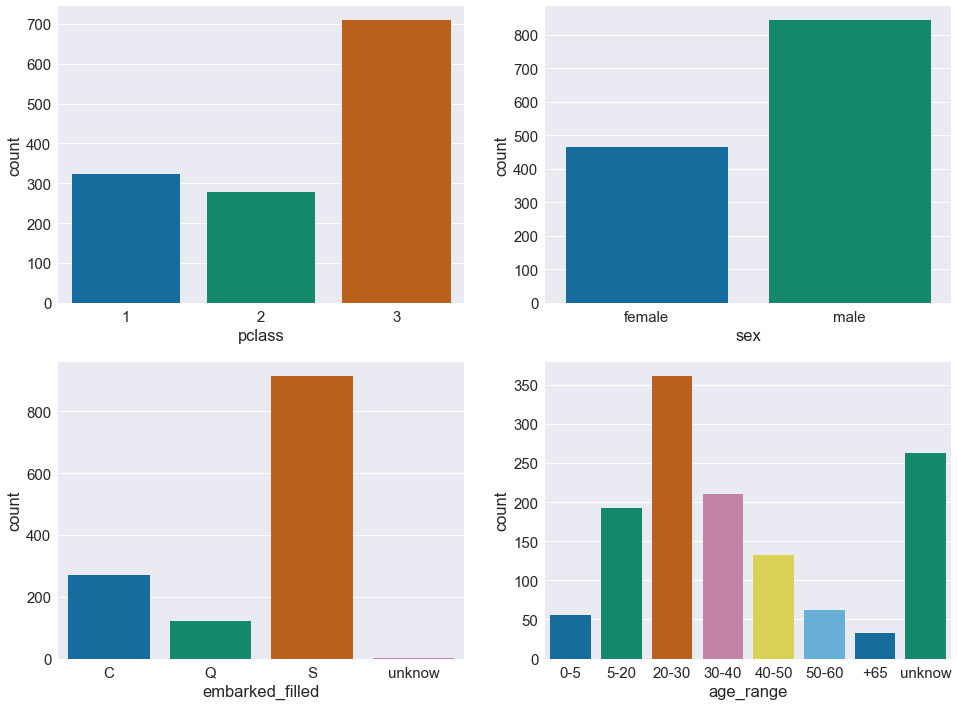

In [49]:
def plots(df, chart_type, features_cols, kwars_chart={}, chart_cols=2):
    '''Plot features_cols of df database using `chart_type` from seaborn'''
    df = discrete_age_and_treat_embk(df)
    
    chart_rows = int((len(features_cols) - 1) / chart_cols + 1)
    partitions = list(partition_all(chart_cols, features_cols))

    fig, axs = plt.subplots(ncols=chart_cols, nrows=chart_rows)
    fig.set_size_inches(8 * chart_cols, 6 * chart_rows)
    
    if chart_rows == 1:
        for i, feature in enumerate(partitions[0]):
            pos = axs[i]
            chart_type(x=feature, data=df, ax=pos, **kwars_chart)
    else:
        for i, set_features in enumerate(partitions):
            for j, feature in enumerate(set_features):
                pos = axs[i][j]
                chart_type(x=feature, data=df, ax=pos, **kwars_chart)
                
plots(titanic, 
      sns.countplot, 
      ['pclass', 'sex', 'embarked_filled', 'age_range'], 
      {'palette': 'colorblind'})

### 3. Calculate the proportion of passengers by cabin floor. Present your results in a pie chart.
It will be considered that the first letter of cabin is the floor.
For the ones that have more than one cabin registred, they have always the same floor in common, so there no is issue regarding treating those just using the first letter. There are a lot of missing cabins, so it will be desconsired from the analysis

In [80]:
missing_cabin = pd.isnull(titanic.cabin).sum()
print('Number of missing cabins: {m} in {r} rows'.format(m=missing_cabin, r=len(titanic)))

Number of missing cabins: 1014 in 1309 rows


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


floor,A,B,C,D,E,F,G,T
n,22.0,65.00,94.00,46.0,41.00,21.00,5.0,1.0
survived,0.5,0.72,0.61,0.7,0.73,0.62,0.6,0.0


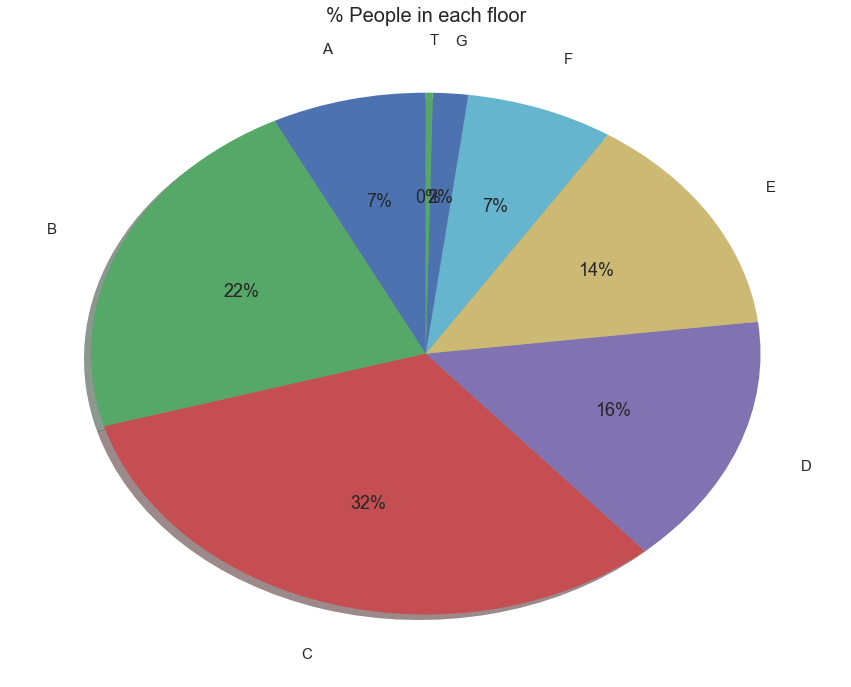

In [82]:
def plot_floor(df):
    df['floor'] = df['cabin'].apply(lambda x: list(x)[0])
    
    grouped = (df[['floor', 'survived']]
               .groupby('floor')
               .agg(['size', 'mean'])['survived']
               .rename(columns={'size': 'n', 'mean': 'survived'}))
    
    fig, axs = plt.subplots(ncols=1, nrows=1)
    fig.set_size_inches(15, 12)

    plt.pie(grouped['n'], 
            labels=list(grouped.index), 
            autopct='%.0f%%', 
            shadow=True, startangle=90,
            labeldistance=1.2);
    plt.title('% People in each floor', fontsize=20)

    return grouped.T.apply(lambda x: round(x, 2), axis=1)
    
plot_floor(titanic[pd.notnull(titanic.cabin)])

### 4. For each travel class, calculate the proportion of the passengers that survived. Present your results in pie charts.

Propotion of each class in titanic:


pclass,1,2,3
0,0.25,0.21,0.54


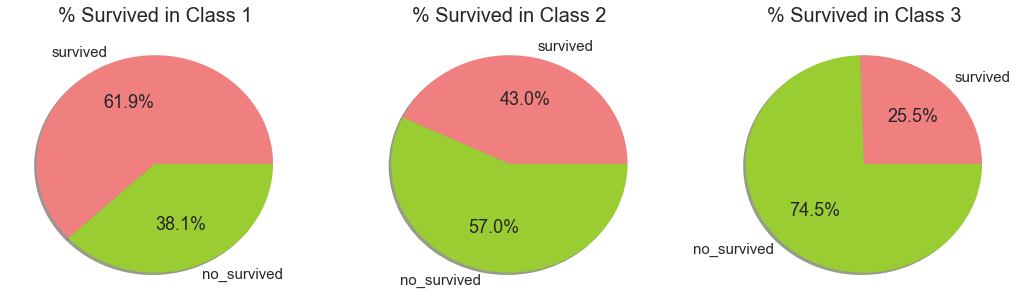

In [19]:
def plot_survived_by_class(df):
    fig, axs = plt.subplots(ncols=3, nrows=1)
    fig.set_size_inches(6 * 3, 5 * 1)
    
    grouped = df.groupby('pclass').mean()[['survived']].reset_index()
    grouped['no_survived'] = 1 - grouped['survived']
    colors = ['lightcoral', 'yellowgreen']
    for i, c in enumerate(list(grouped.pclass)):
        df_plot = grouped[grouped.pclass==c][['survived', 'no_survived']].T
        axs[i].pie(df_plot, labels=list(df_plot.index), colors=colors, autopct='%1.1f%%', shadow=True);
        axs[i].set_title('% Survived in Class {c}'.format(c=c), fontsize=20)
        
plot_survived_by_class(titanic)
print('Propotion of each class in titanic:')
pd.DataFrame(pd.DataFrame(titanic.groupby('pclass').size())[0].apply(lambda x: round(x / len(titanic), 2))).T

### 5. Calculate the proportion of the passengers that survived by travel class and sex. Present your results in a single histogram.

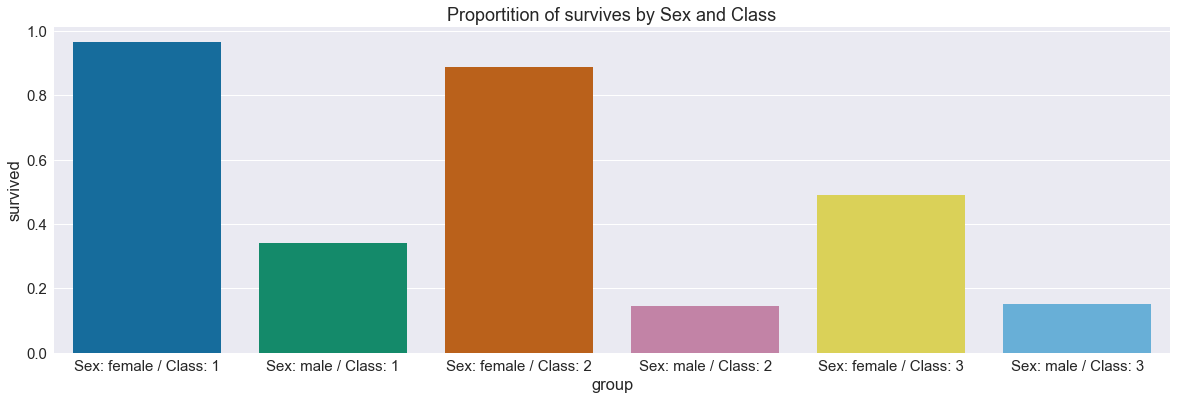

In [20]:
def survived_by_class_sex(df):
    grouped = pd.DataFrame(df.groupby(['pclass', 'sex']).mean())[['survived']].reset_index()
    grouped['group'] = grouped.apply(lambda x: 'Sex: {} / Class: {}'.format(x['sex'], x['pclass']), axis=1)
    fig, axs = plt.subplots(ncols=1, nrows=1)
    fig.set_size_inches(20, 6)
    sns.barplot(y='survived', x='group', data=grouped, palette='colorblind')
    plt.title('Proportition of survives by Sex and Class')

survived_by_class_sex(titanic)

### 6. Create 2 equally populated age categories and calculate survival proportions by age category, travel class and sex. Present your results in a DataFrame with unique index.
In this case, travelers with age equal nan won't be include in the analysis

In [21]:
titanic_valid_age = titanic[pd.notnull(titanic.age)]
median_age = titanic_valid_age.age.median()
titanic_valid_age['age_category'] = titanic_valid_age.age.apply(lambda x: '< 28' if x<28 else '>= 28')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
pd.DataFrame(titanic_valid_age.groupby(['age_category', 'pclass', 'sex']).mean()['survived']).apply(lambda x: round(x,3)).reset_index()

,age_category,pclass,sex,survived
0,< 28,1,female,0.950
1,< 28,1,male,0.536
2,< 28,2,female,0.902
3,< 28,2,male,0.235
4,< 28,3,female,0.528
5,< 28,3,male,0.194
6,>= 28,1,female,0.968
7,>= 28,1,male,0.309
8,>= 28,2,female,0.885
9,>= 28,2,male,0.078


Individually we have:

In [23]:
pd.DataFrame(titanic_valid_age.groupby(['age_category']).mean()['survived']).apply(lambda x: round(x,3)).reset_index()

,age_category,survived
0,< 28,0.421
1,>= 28,0.397


In [24]:
pd.DataFrame(titanic_valid_age.groupby(['pclass']).mean()['survived']).apply(lambda x: round(x,3)).reset_index()

,pclass,survived
0,1,0.637
1,2,0.441
2,3,0.261


In [25]:
pd.DataFrame(titanic_valid_age.groupby(['sex']).mean()['survived']).apply(lambda x: round(x,3)).reset_index()

,sex,survived
0,female,0.753
1,male,0.205
